In [55]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,forest
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn import tree
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sn
import pickle
import pandas.util.testing as tm

In [44]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
trainX[:2]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

## Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| :-------------------: |  :-------------------: |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


In [45]:
labels, indices = np.unique(trainY[15:], return_index=True)

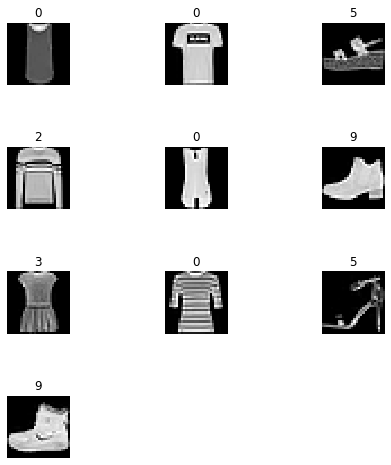

In [46]:
def print_exmple(trainX):
    fig = plt.figure(figsize=(8,8))
    for count,index in enumerate(indices):
        ax = fig.add_subplot(4, 3, count+1)
        ax.imshow(trainX[index], cmap=plt.get_cmap('gray'))
        ax.axis("off")
        ax.set_title(trainY[index])
    plt.subplots_adjust(hspace=1)
    plt.show()
    
print_exmple(trainX)

In [14]:
train_df = pd.DataFrame(trainX.reshape(len(testX),28*28))
corr = train_df.corr()

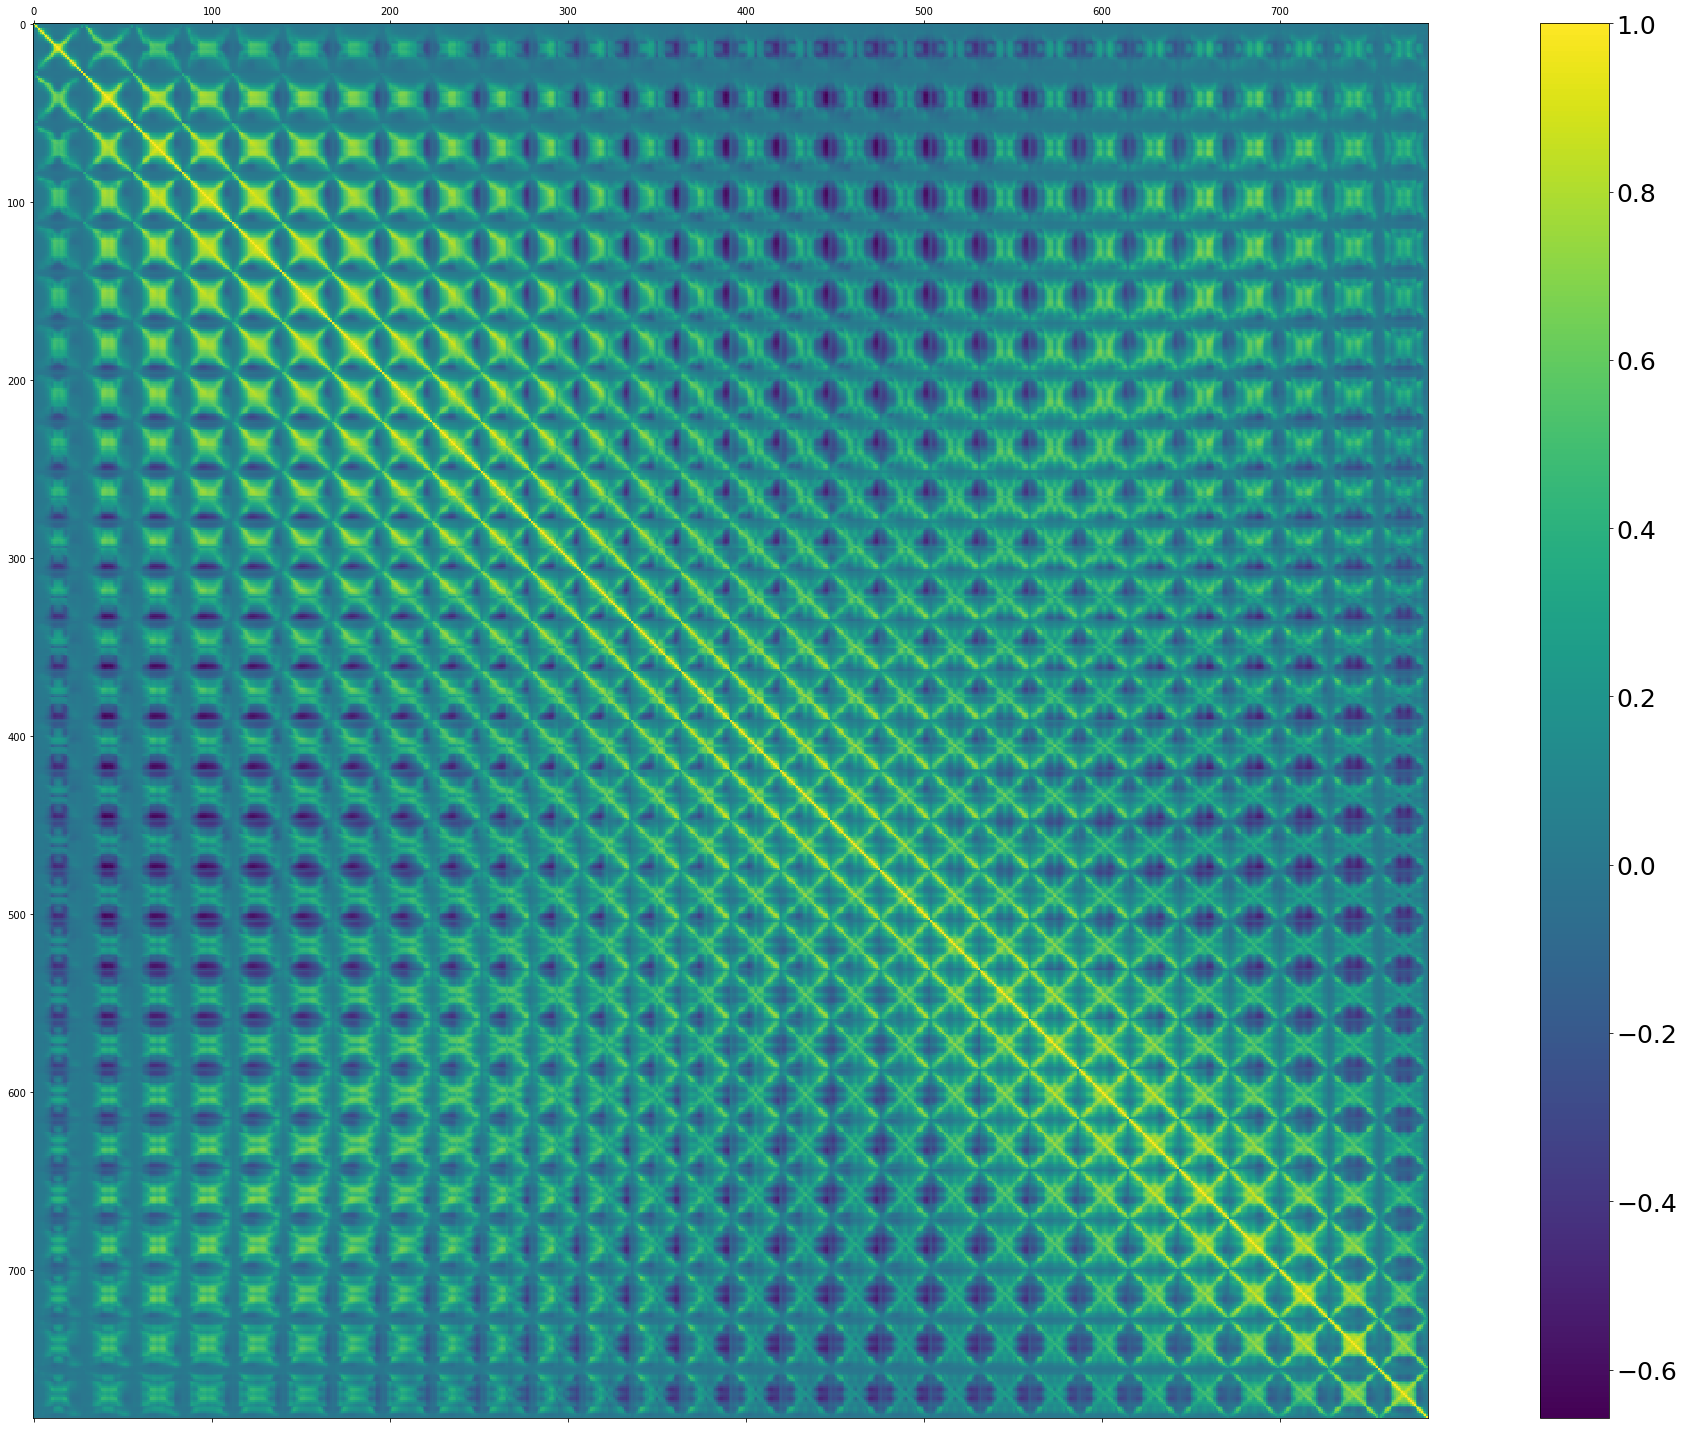

In [21]:
f = plt.figure(figsize=(40, 25))
plt.matshow(corr, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
plt.show()

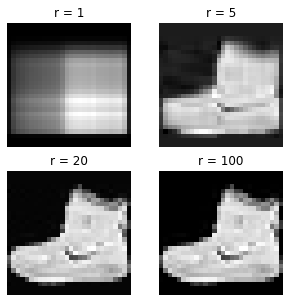

In [21]:
U,S,V_t = np.linalg.svd(trainX[0],full_matrices=False)
S = np.diag(S)
fig = plt.figure(figsize=(5,5))

for j,r in enumerate([1,5,20,100]):
    X = U[:,:r] @ S[0:r,:r] @ V_t[:r,:]
    ax = fig.add_subplot(2, 2, j+1)
    img = plt.imshow(X)
    img.set_cmap("gray")
    ax.axis("off")
    ax.set_title("r = " + str(r))
plt.show()

In [31]:
X = trainX.reshape(len(trainX),28*28)
X = X - np.mean(X)
U,S,V_t = np.linalg.svd(X,full_matrices=False)
S = np.diag(S)

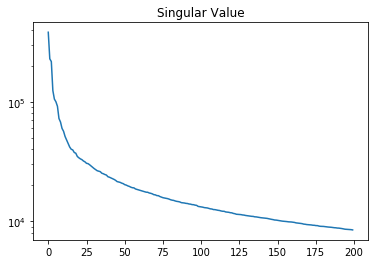

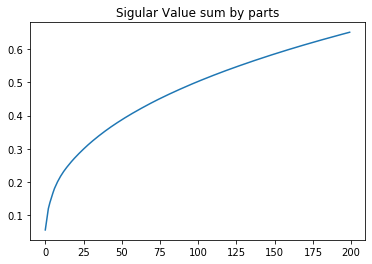

In [74]:
plt.figure(1)
plt.semilogy(np.diag(S[:200]))
plt.title("Singular Value")
plt.show()

plt.figure(2)
plt.plot(np.cumsum(np.diag(S[:200]))/np.sum(np.diag(S)))
plt.title("Sigular Value sum by parts")
plt.show()

In [47]:
print(trainX.shape)
trainX = trainX.reshape(len(trainX),28*28)
print(trainX.shape)
testX = testX.reshape(len(testX),28*28)

(60000, 28, 28)
(60000, 784)


In [75]:
def get_pcs(n_components):
    pca = PCA(n_components=n_components)
    pca.fit(trainX)
    X_pc = pca.transform(trainX)
    n_pcs= pca.components_.shape[0]
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    initial_feature_names = range(28*28)
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
    df = pd.DataFrame(dic.items())
    return df,pca
df,pca = get_pcs(n_components=50)
df

0    1
0    PC0  150
1    PC1  414
2    PC2  398
3    PC3  680
4    PC4  742
5    PC5  228
6    PC6  396
7    PC7  104
8    PC8   46
9    PC9  651
10  PC10  740
11  PC11  749
12  PC12  512
13  PC13  541
14  PC14  299
15  PC15  524
16  PC16   15
17  PC17  184
18  PC18  693
19  PC19  331
20  PC20  579
21  PC21  491
22  PC22  511
23  PC23  688
24  PC24   16
25  PC25  553
26  PC26  540
27  PC27  327
28  PC28  539
29  PC29  496
30  PC30  525
31  PC31  103
32  PC32  749
33  PC33   15
34  PC34  693
35  PC35   15
36  PC36  494
37  PC37  242
38  PC38  691
39  PC39  349
40  PC40  185
41  PC41   15
42  PC42  686
43  PC43   42
44  PC44  356
45  PC45  654
46  PC46   46
47  PC47  412
48  PC48  691
49  PC49  743

In [76]:
np.sum(pca.explained_variance_ratio_)

0.8626297693543318

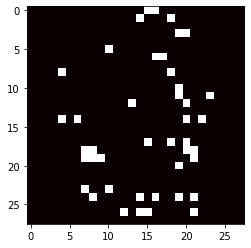

In [77]:
filterd_features = df[1]
features = np.zeros(28*28,dtype=int)
for i in filterd_features:
    features[i]=255
plt.imshow(features.reshape(28,28),cmap="hot",interpolation='nearest')

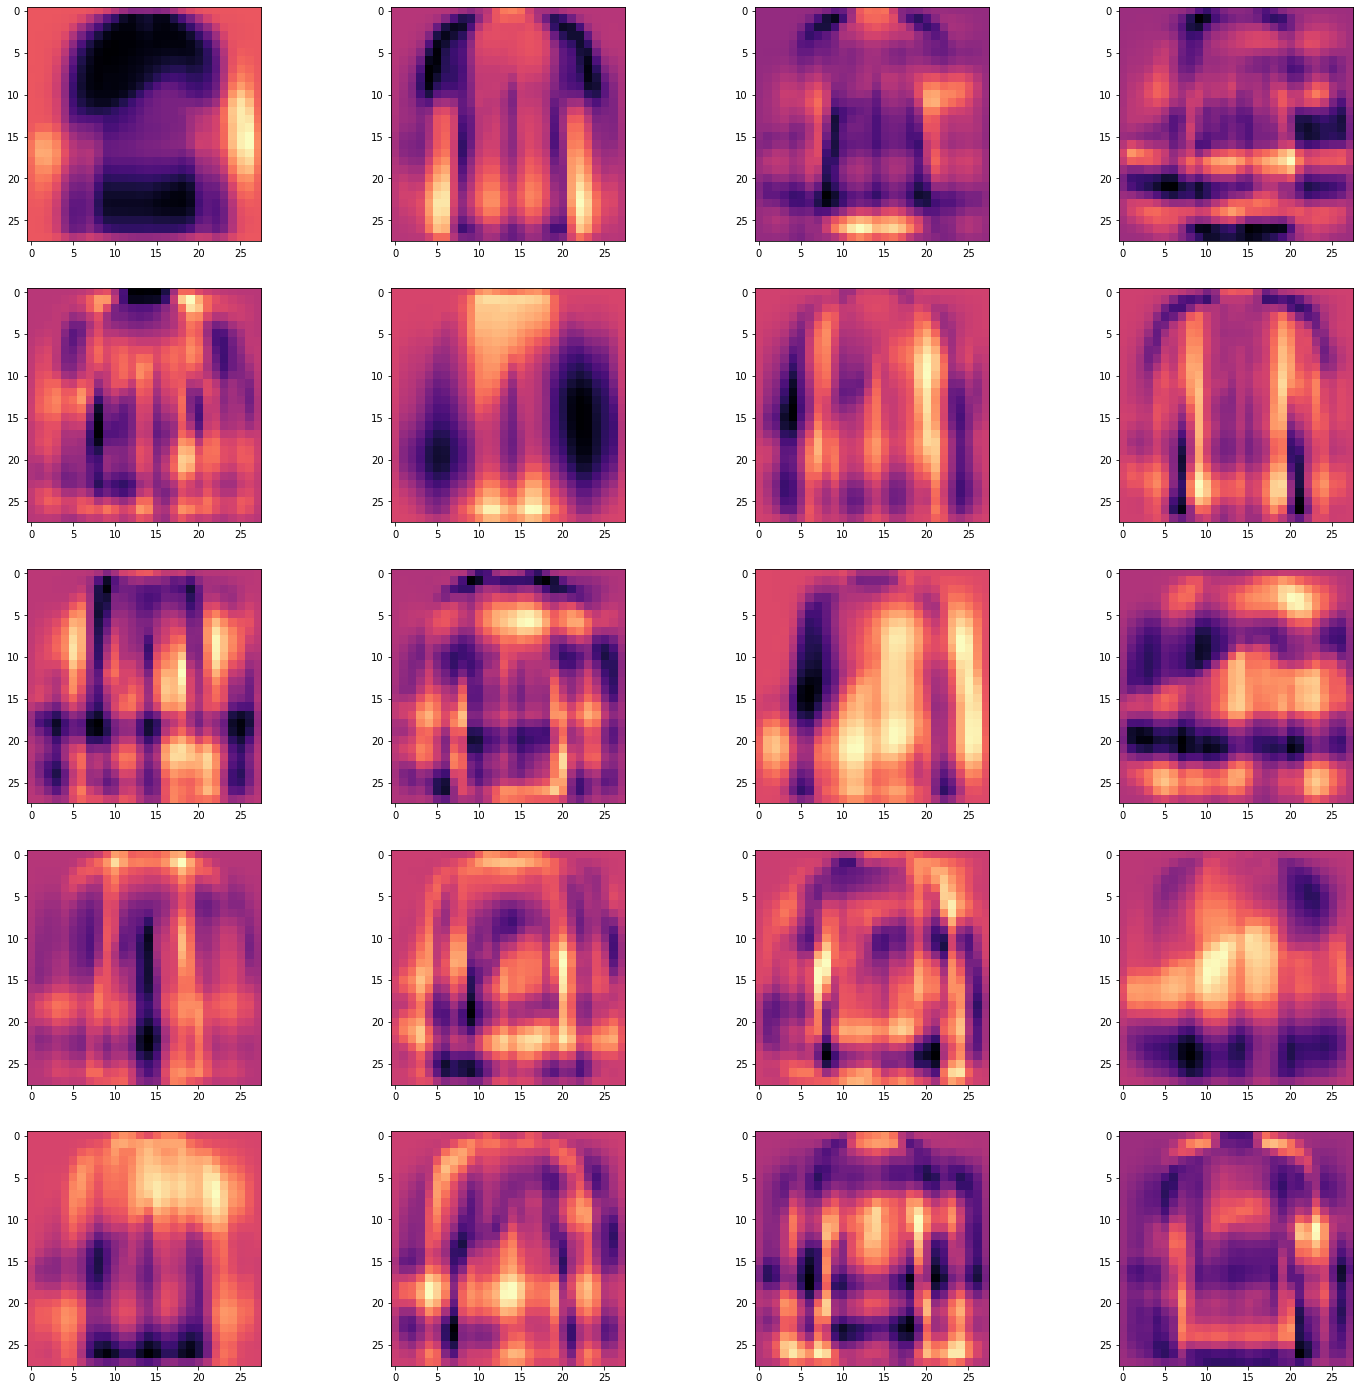

In [78]:
fig,ax = plt.subplots(5,4,figsize=(25,25))
for i,pca_com in enumerate(pca.components_[:20]):
    ax[i%5][i%4].imshow(pca_com.reshape(28,28),cmap="magma_r",interpolation='nearest')
plt.show()

In [79]:
pca = PCA(n_components=0.85)
pca.fit(trainX)
compressed_trainX = pca.transform(trainX)
decompressed_trainX = pca.inverse_transform(compressed_trainX)
compressed_testX = pca.transform(testX)
decompressed_testX = pca.inverse_transform(compressed_testX)

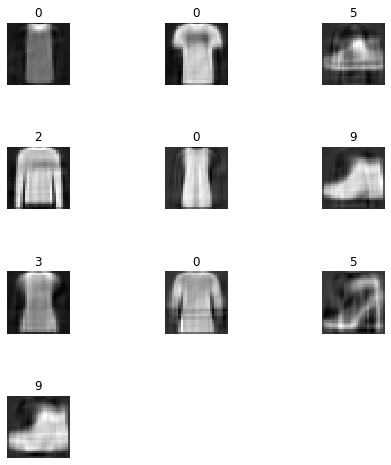

In [80]:
print_exmple(decompressed_trainX.reshape(len(decompressed_trainX),28,28))

In [72]:
def validate(model,x_train,x_test):
    model.fit(x_train, trainY)
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=93)
    scores = cross_val_score(model,x_test, testY, cv=kfold)*100
    return("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

In [7]:
svc=SVC(C=10,kernel='poly',gamma="auto")
svc.fit(trainX,trainY)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
y_pred = svc.predict(testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1000
           1       0.97      0.98      0.97      1000
           2       0.75      0.82      0.78      1000
           3       0.88      0.85      0.87      1000
           4       0.81      0.77      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.70      0.65      0.68      1000
           7       0.95      0.94      0.95      1000
           8       0.96      0.96      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [19]:
svc=SVC(C=10,kernel='poly',gamma="auto")
svc.fit(compressed_trainX,trainY)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [20]:
y_pred = svc.predict(compressed_testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.79      0.82      0.80      1000
           3       0.91      0.90      0.90      1000
           4       0.82      0.81      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.69      0.70      1000
           7       0.94      0.96      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [73]:
naive_bayes_model = GaussianNB()
#print(validate(naive_bayes_model,trainX,testX))
print(validate(naive_bayes_model,compressed_trainX,compressed_testX))

76.50% (+/- 0.96%)


In [12]:
naive_bayes_model.fit(compressed_trainX,trainY)
y_pred = naive_bayes_model.predict(compressed_testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1000
           1       0.95      0.87      0.91      1000
           2       0.70      0.63      0.66      1000
           3       0.80      0.73      0.76      1000
           4       0.72      0.67      0.69      1000
           5       0.79      0.71      0.75      1000
           6       0.51      0.49      0.50      1000
           7       0.74      0.85      0.79      1000
           8       0.59      0.85      0.70      1000
           9       0.93      0.85      0.89      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1000
           1       0.66      0.92      0.77      1000
           2       0.70      0.63      0.66      1000
           3       0.82      0.55      0.66      1000
           4       0.72      0.66      0.69      1000
           5       0.79      0.71      0.75      1000
           6       0.51      0.44      0.47      1000
           7       0.74      0.85      0.79      1000
           8       0.59      0.85      0.70      1000
           9       0.93      0.85      0.89      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



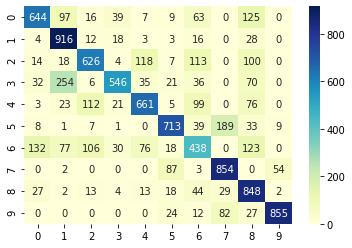

In [62]:
def predict_with_bias(model,x_test,bias,HIGH_PRIORITY_CLASS = 1):
    y_pred_prob = model.predict_proba(x_test)
    y_pred = []
    for sample in y_pred_prob:
        if(sample[HIGH_PRIORITY_CLASS]<bias):
            y_pred.append(np.argmax(sample))
        else:
            y_pred.append(HIGH_PRIORITY_CLASS)
    ax = sn.heatmap(confusion_matrix(testY, y_pred), cmap="YlGnBu",annot=True, fmt="d")
    print(classification_report(testY, y_pred))
predict_with_bias(naive_bayes_model,compressed_testX,10**(-5))

In [81]:
weak_learner = tree.DecisionTreeClassifier(max_depth=10)
adaboost_model = AdaBoostClassifier(weak_learner,n_estimators=100,random_state=93,learning_rate=0.8)
adaboost_model.fit(trainX,trainY)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                            

In [82]:
y_pred = adaboost_model.predict(testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1000
           1       1.00      0.93      0.96      1000
           2       0.75      0.71      0.73      1000
           3       0.85      0.86      0.85      1000
           4       0.73      0.71      0.72      1000
           5       0.95      0.93      0.94      1000
           6       0.53      0.64      0.58      1000
           7       0.88      0.91      0.89      1000
           8       0.97      0.95      0.96      1000
           9       0.93      0.91      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



In [24]:
adaboost_model = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=10),n_estimators=100)
adaboost_model.fit(compressed_trainX,trainY)
y_pred = adaboost_model.predict(compressed_testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.69      0.73      1000
           1       0.99      0.90      0.94      1000
           2       0.61      0.66      0.64      1000
           3       0.80      0.81      0.81      1000
           4       0.67      0.59      0.63      1000
           5       0.90      0.91      0.90      1000
           6       0.43      0.57      0.49      1000
           7       0.89      0.87      0.88      1000
           8       0.93      0.89      0.91      1000
           9       0.91      0.92      0.91      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [19]:
param_list = [("eta", 0.08), ("max_depth", 6), ("subsample", 0.8), ("colsample_bytree", 0.8), ("objective", "multi:softmax"), ("eval_metric", "merror"), ("alpha", 8), ("lambda", 2), ("num_class", 10)]
n_rounds = 600
early_stopping = 50
    
d_train = xgb.DMatrix(trainX, label=trainY)
d_val = xgb.DMatrix(testX, label=testY)
eval_list = [(d_train, "train"), (d_val, "validation")]
bst = xgb.train(param_list, d_train, n_rounds, evals=eval_list, early_stopping_rounds=early_stopping, verbose_eval=True)

[0]	train-merror:0.17748	validation-merror:0.20080
Multiple eval metrics have been passed: 'validation-merror' will be used for early stopping.

Will train until validation-merror hasn't improved in 50 rounds.
[1]	train-merror:0.15942	validation-merror:0.18090
[2]	train-merror:0.15333	validation-merror:0.17660
[3]	train-merror:0.14958	validation-merror:0.17280
[4]	train-merror:0.14758	validation-merror:0.17230
[5]	train-merror:0.14512	validation-merror:0.16880
[6]	train-merror:0.14215	validation-merror:0.16760
[7]	train-merror:0.14095	validation-merror:0.16510
[8]	train-merror:0.13877	validation-merror:0.16310
[9]	train-merror:0.13762	validation-merror:0.16200
[10]	train-merror:0.13692	validation-merror:0.16060
[11]	train-merror:0.13592	validation-merror:0.16110
[12]	train-merror:0.13460	validation-merror:0.16030
[13]	train-merror:0.13375	validation-merror:0.16060
[14]	train-merror:0.13267	validation-merror:0.15900
[15]	train-merror:0.13160	validation-merror:0.15820
[16]	train-merror:0

[154]	train-merror:0.05233	validation-merror:0.11390
[155]	train-merror:0.05188	validation-merror:0.11390
[156]	train-merror:0.05157	validation-merror:0.11340
[157]	train-merror:0.05127	validation-merror:0.11310
[158]	train-merror:0.05083	validation-merror:0.11280
[159]	train-merror:0.05065	validation-merror:0.11300
[160]	train-merror:0.05018	validation-merror:0.11280
[161]	train-merror:0.04965	validation-merror:0.11300
[162]	train-merror:0.04937	validation-merror:0.11290
[163]	train-merror:0.04910	validation-merror:0.11290
[164]	train-merror:0.04842	validation-merror:0.11290
[165]	train-merror:0.04817	validation-merror:0.11280
[166]	train-merror:0.04785	validation-merror:0.11300
[167]	train-merror:0.04767	validation-merror:0.11270
[168]	train-merror:0.04728	validation-merror:0.11180
[169]	train-merror:0.04678	validation-merror:0.11160
[170]	train-merror:0.04652	validation-merror:0.11170
[171]	train-merror:0.04607	validation-merror:0.11190
[172]	train-merror:0.04585	validation-merror:0

[309]	train-merror:0.01720	validation-merror:0.10380
[310]	train-merror:0.01702	validation-merror:0.10370
[311]	train-merror:0.01690	validation-merror:0.10340
[312]	train-merror:0.01680	validation-merror:0.10350
[313]	train-merror:0.01667	validation-merror:0.10340
[314]	train-merror:0.01667	validation-merror:0.10350
[315]	train-merror:0.01652	validation-merror:0.10350
[316]	train-merror:0.01638	validation-merror:0.10360
[317]	train-merror:0.01633	validation-merror:0.10340
[318]	train-merror:0.01622	validation-merror:0.10310
[319]	train-merror:0.01617	validation-merror:0.10300
[320]	train-merror:0.01608	validation-merror:0.10310
[321]	train-merror:0.01597	validation-merror:0.10310
[322]	train-merror:0.01592	validation-merror:0.10360
[323]	train-merror:0.01582	validation-merror:0.10330
[324]	train-merror:0.01567	validation-merror:0.10350
[325]	train-merror:0.01560	validation-merror:0.10330
[326]	train-merror:0.01547	validation-merror:0.10320
[327]	train-merror:0.01542	validation-merror:0

[464]	train-merror:0.00592	validation-merror:0.10040
[465]	train-merror:0.00585	validation-merror:0.10050
[466]	train-merror:0.00582	validation-merror:0.10050
[467]	train-merror:0.00578	validation-merror:0.10060
[468]	train-merror:0.00578	validation-merror:0.10060
[469]	train-merror:0.00578	validation-merror:0.10020
[470]	train-merror:0.00575	validation-merror:0.10040
[471]	train-merror:0.00565	validation-merror:0.10040
[472]	train-merror:0.00562	validation-merror:0.10080
[473]	train-merror:0.00563	validation-merror:0.10040
[474]	train-merror:0.00560	validation-merror:0.10050
[475]	train-merror:0.00553	validation-merror:0.10060
[476]	train-merror:0.00550	validation-merror:0.10040
[477]	train-merror:0.00548	validation-merror:0.10050
[478]	train-merror:0.00540	validation-merror:0.10050
[479]	train-merror:0.00540	validation-merror:0.10020
[480]	train-merror:0.00537	validation-merror:0.10040
[481]	train-merror:0.00538	validation-merror:0.10030
[482]	train-merror:0.00537	validation-merror:0

In [27]:

d_test = xgb.DMatrix(data=testX)
y_pred = bst.predict(d_test)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.84      0.83      1000
           3       0.90      0.92      0.91      1000
           4       0.83      0.84      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.75      0.68      0.71      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [76]:
#predict_with_bias(bst,d_test,0.1,7)

In [5]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [12]:
pca = PCA(n_components=0.95)
pca.fit(trainX)
most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]

In [21]:
set_rf_samples(5000)
clf = RandomForestClassifier(n_estimators=100,max_depth=100)
%time clf.fit(trainX,trainY)
print(clf.score(testX,testY))
reset_rf_samples()

Wall time: 16 s


0.85

In [7]:
rnd_clf = RandomForestClassifier(n_estimators=100,max_depth=100)
rnd_clf = rnd_clf.fit(trainX,trainY)
y_pred = rnd_clf.predict(testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.80      0.78      1000
           3       0.87      0.90      0.89      1000
           4       0.77      0.81      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.60      0.65      1000
           7       0.92      0.95      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



In [10]:
rnd_clf = RandomForestClassifier(n_estimators=100,max_depth=100)
rnd_clf = rnd_clf.fit(compressed_trainX,trainY)

In [15]:
y_pred = rnd_clf.predict(compressed_testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1000
           1       1.00      0.95      0.97      1000
           2       0.74      0.79      0.77      1000
           3       0.86      0.90      0.88      1000
           4       0.77      0.78      0.78      1000
           5       0.93      0.93      0.93      1000
           6       0.69      0.54      0.61      1000
           7       0.92      0.93      0.93      1000
           8       0.92      0.95      0.94      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.86      0.85     10000



              precision    recall  f1-score   support

           0       0.67      0.77      0.71      1000
           1       0.46      0.98      0.63      1000
           2       0.67      0.60      0.64      1000
           3       0.68      0.16      0.26      1000
           4       0.64      0.64      0.64      1000
           5       0.74      0.78      0.76      1000
           6       0.60      0.29      0.39      1000
           7       0.83      0.82      0.82      1000
           8       0.81      0.84      0.83      1000
           9       0.86      0.87      0.87      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.65     10000
weighted avg       0.69      0.68      0.65     10000



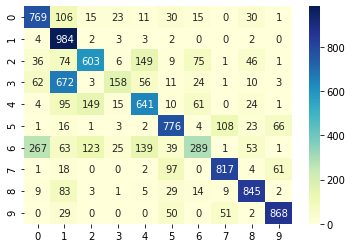

In [63]:
predict_with_bias(rnd_clf,compressed_testX,0.08)

In [84]:
def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
    return predicted_labels

In [85]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    for i in range(kmeans.n_clusters):
        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])#count the occurrence
        else:
            counts = np.bincount(np.squeeze(labels))
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]
    return inferred_labels

In [82]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(compressed_trainX)
cluster_labels = infer_cluster_labels(kmeans, trainY)
X_clusters = kmeans.predict(compressed_testX)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(classification_report(testY, predicted_labels))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1000
           1       1.00      0.92      0.96      1000
           2       0.61      0.60      0.60      1000
           3       0.78      0.84      0.81      1000
           4       0.63      0.60      0.62      1000
           5       0.92      0.82      0.87      1000
           6       0.51      0.42      0.46      1000
           7       0.82      0.89      0.85      1000
           8       0.91      0.94      0.93      1000
           9       0.89      0.91      0.90      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [86]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(trainX)
cluster_labels = infer_cluster_labels(kmeans, trainY)
X_clusters = kmeans.predict(testX)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(classification_report(testY, predicted_labels))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1000
           1       0.99      0.92      0.96      1000
           2       0.63      0.63      0.63      1000
           3       0.77      0.83      0.80      1000
           4       0.64      0.62      0.63      1000
           5       0.90      0.84      0.87      1000
           6       0.50      0.41      0.45      1000
           7       0.84      0.83      0.84      1000
           8       0.93      0.93      0.93      1000
           9       0.86      0.93      0.89      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [12]:
knn = KNeighborsClassifier(n_neighbors=5,p=1,weights="distance")
knn.fit(trainX,trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='distance')

In [13]:
y_pred = knn.predict(testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.74      0.79      0.76      1000
           3       0.91      0.88      0.89      1000
           4       0.77      0.76      0.76      1000
           5       0.99      0.90      0.94      1000
           6       0.64      0.59      0.61      1000
           7       0.91      0.95      0.93      1000
           8       0.98      0.95      0.97      1000
           9       0.92      0.97      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [66]:
scores = []
for depth in range(2,200,3):
    decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=depth)
    scores.append(validate(decision_tree,compressed_trainX,compressed_testX))
print(np.argmax(scores))
#tree.plot_tree(decision_tree)

3


0.7248


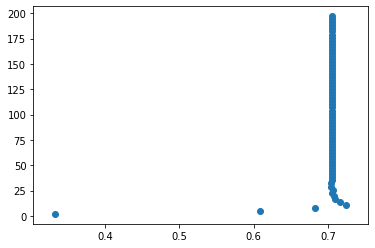

In [72]:
plt.scatter(scores,range(2,200,3))
print(np.max(scores))

In [73]:
best_decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=11)
best_decision_tree = best_decision_tree.fit(compressed_trainX,trainY)
y_pred = best_decision_tree.predict(compressed_testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.79      0.72      1000
           1       0.96      0.93      0.94      1000
           2       0.65      0.64      0.64      1000
           3       0.76      0.79      0.77      1000
           4       0.56      0.73      0.64      1000
           5       0.88      0.80      0.84      1000
           6       0.59      0.35      0.44      1000
           7       0.82      0.87      0.84      1000
           8       0.89      0.86      0.88      1000
           9       0.89      0.87      0.88      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [77]:
best_decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=11)
best_decision_tree = best_decision_tree.fit(trainX,trainY)
y_pred = best_decision_tree.predict(testX)
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1000
           1       0.97      0.93      0.95      1000
           2       0.66      0.70      0.68      1000
           3       0.83      0.80      0.81      1000
           4       0.62      0.76      0.69      1000
           5       0.93      0.88      0.90      1000
           6       0.59      0.46      0.52      1000
           7       0.88      0.91      0.89      1000
           8       0.92      0.91      0.92      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1000
           1       0.96      0.91      0.93      1000
           2       0.65      0.63      0.64      1000
           3       0.80      0.77      0.79      1000
           4       0.59      0.70      0.64      1000
           5       0.30      0.95      0.45      1000
           6       0.59      0.35      0.44      1000
           7       0.66      0.08      0.14      1000
           8       0.93      0.31      0.47      1000
           9       0.92      0.72      0.81      1000

    accuracy                           0.61     10000
   macro avg       0.72      0.61      0.60     10000
weighted avg       0.72      0.61      0.60     10000



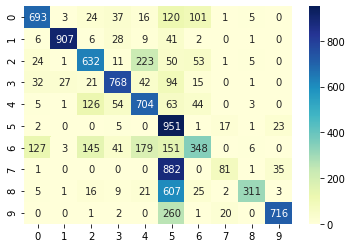

In [75]:
predict_with_bias(best_decision_tree,compressed_testX,0.01,5)

In [55]:
x_train = trainX.reshape(trainX.shape[0], -1) / 255.0
x_test = testX.reshape(testX.shape[0], -1) / 255.0
y_train = to_categorical(trainY)
y_test = to_categorical(testY)

In [56]:
model = Sequential()

model.add(Dense(10, input_dim=784, activation='relu'))#hidden layer
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))#output layer, Softmax - more than two categories,(Sigmoid - two categories)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#loss(multi-categories=categorical_crossentropy, two-categories=binary_crossentropy),optimizer(adam or rmsprop)

In [57]:
model.fit(x_train, y_train, epochs=10, validation_split=0.1)
_, test_acc = model.evaluate(x_test, y_test)
print(test_acc)

Epoch 1/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6469 - accuracy: 0.7694 - val_loss: 0.4826 - val_accuracy: 0.8298
Epoch 2/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4560 - accuracy: 0.8403 - val_loss: 0.4312 - val_accuracy: 0.8462
Epoch 3/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4196 - accuracy: 0.8505 - val_loss: 0.4142 - val_accuracy: 0.8503
Epoch 4/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3999 - accuracy: 0.8545 - val_loss: 0.4085 - val_accuracy: 0.8507
Epoch 5/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3879 - accuracy: 0.8584 - val_loss: 0.3933 - val_accuracy: 0.8570
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3754 - accuracy: 0.8632 - val_loss: 0.4103 - val_accuracy: 0.8488
Epoch 7/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3683 - accuracy: 0.8654 - val_loss: 0.3886 - val_accuracy:

In [61]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
x_train = trainX[:,:,:,np.newaxis] / 255.0
x_test = testX[:,:,:,np.newaxis] / 255.0

In [62]:
model4 = Sequential()
model4.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28, 1))) 
model4.add(MaxPooling2D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(10, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model4.summary()
model4.fit(x_train, y_train, epochs=10, validation_split=0.1)
_, test_acc = model4.evaluate(x_test, y_test)
print(test_acc)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                125450    
Total params: 125,770
Trainable params: 125,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1688/1688 [==============================] - 52s 31ms/step - loss: 0.4316 - accuracy: 0.8513 - val_loss: 0.3379 - val_accuracy: 0.8787
Epoch 2/10
1688/1688 [==============================] - 48s 28ms/step - loss: 0.3101 - accuracy: 0.8

## Save For Next Notebook

In [9]:
file = open("UsefullFunctions.d","wb")
funcs = {"pca":get_pcs,"set_rf":set_rf_samples,"reset_rf":reset_rf_samples}
pickle.dump(funcs,file)